## RNA Preprocessing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/a-nadeem9/brca-epigenetic-age-acceleration-immune-multiomics-classifier/blob/main/notebooks/01b_rna_preprocessing.ipynb)


In [2]:
import pandas as pd

# Load raw RNA‐seq count matrix
rna_path = '../data/rna_seq_matched_final.h5'
rna_df   = pd.read_hdf(rna_path, key='rna')   # rows=genes, cols=samples

print(f"Raw counts matrix: {rna_df.shape[0]} genes × {rna_df.shape[1]} samples")


Raw counts matrix: 60660 genes × 693 samples


In [3]:
# 1) Calculate library sizes (total counts per sample)
lib_sizes = rna_df.sum(axis=0)

# 2) Compute CPM matrix
cpm = rna_df.div(lib_sizes, axis=1) * 1e6

# 3) Quick sanity check
print(f"CPM matrix stats: min={cpm.values.min():.2f}, max={cpm.values.max():.2f}")
print(f"Mean CPM for first gene: {cpm.iloc[0].mean():.2f}")


CPM matrix stats: min=0.00, max=114092.12
Mean CPM for first gene: 51.42


In [4]:
import numpy as np

# Define filter thresholds
min_cpm     = 1      # CPM threshold
min_frac    = 0.2    # fraction of samples
n_samples   = cpm.shape[1]
min_samples = int(np.ceil(min_frac * n_samples))

# Create boolean mask: gene passes if CPM > min_cpm in ≥ min_samples
keep_mask = (cpm > min_cpm).sum(axis=1) >= min_samples

# Subset your raw counts matrix
filtered_rna = rna_df.loc[keep_mask]

print(f"Kept {filtered_rna.shape[0]} genes "
      f"({keep_mask.mean()*100:.1f}% of total).")


Kept 17181 genes (28.3% of total).


In [5]:
# 1) Subset the CPM matrix to your filtered genes
filtered_cpm = cpm.loc[filtered_rna.index]

# 2) Apply log2(CPM + 1)
vst_rna = np.log2(filtered_cpm + 1)

# 3) Quick check
print(f"VST matrix: {vst_rna.shape[0]} genes × {vst_rna.shape[1]} samples")
print(f"Example values (first gene): min={vst_rna.iloc[0].min():.2f}, max={vst_rna.iloc[0].max():.2f}")


VST matrix: 17181 genes × 693 samples
Example values (first gene): min=1.89, max=9.77


In [6]:
# Save the VST matrix to HDF5 for later use
output_path = '../data/rna_seq_vst_filtered.h5'
vst_rna.to_hdf(output_path, key='vst', mode='w')

print(f"Saved VST matrix to {output_path}")


Saved VST matrix to ../data/rna_seq_vst_filtered.h5


In [7]:
import pandas as pd
from sklearn.decomposition import PCA

# 1) Load the VST matrix
vst_path = '../data/rna_seq_vst_filtered.h5'
vst_rna = pd.read_hdf(vst_path, key='vst')   # genes × samples

# 2) Transpose so samples × genes
X = vst_rna.T

# 3) Fit PCA (e.g., top 10 components)
pca = PCA(n_components=10)
pcs = pca.fit_transform(X)

# 4) Inspect results
print(f"PCA result shape: {pcs.shape}  # samples × components")
print("Explained variance ratio (first 5 PCs):")
print(pca.explained_variance_ratio_[:5])


PCA result shape: (693, 10)  # samples × components
Explained variance ratio (first 5 PCs):
[0.12929444 0.09535642 0.07509012 0.03643569 0.03415443]


In [11]:
import pandas as pd
from sklearn.decomposition import PCA

# Reload clinical annotations
clin_path = '../data/clinical_matched_final.h5'
clin_df   = pd.read_hdf(clin_path, key='clinical')

# Reload your VST matrix and recompute PCA if needed
vst_path = '../data/rna_seq_vst_filtered.h5'
vst_rna  = pd.read_hdf(vst_path, key='vst').T  # samples × genes

pca      = PCA(n_components=10)
pcs      = pca.fit_transform(vst_rna)


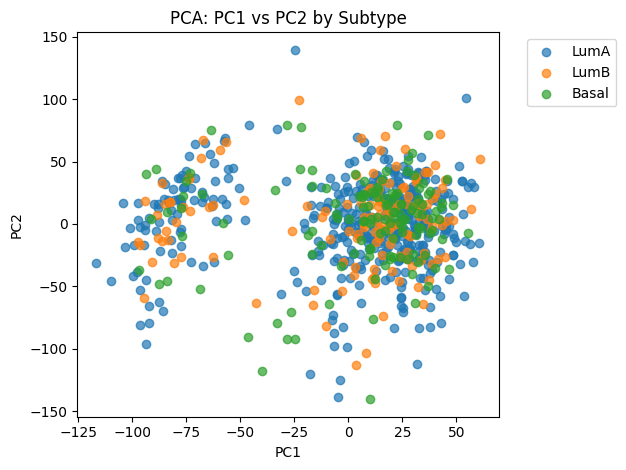

In [12]:
import matplotlib.pyplot as plt

# Construct a DataFrame of PCs
pc_df = pd.DataFrame(
    pcs,
    index=clin_df['bcr_patient_barcode'].astype(str),
    columns=[f'PC{i+1}' for i in range(pcs.shape[1])]
)

# Merge subtype information
pc_df = pc_df.join(
    clin_df.set_index('bcr_patient_barcode')['Subtype'],
    how='left'
)

# Scatter PC1 vs PC2 colored by subtype
plt.figure()
for subtype in pc_df['Subtype'].unique():
    sel = pc_df['Subtype'] == subtype
    plt.scatter(
        pc_df.loc[sel, 'PC1'],
        pc_df.loc[sel, 'PC2'],
        label=subtype,
        alpha=0.7
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 vs PC2 by Subtype')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [13]:
# Merge LumA & LumB into a single “Luminal” category
clin_df['Subtype_merged'] = clin_df['Subtype'].replace({
    'LumA': 'Luminal',
    'LumB': 'Luminal'
})


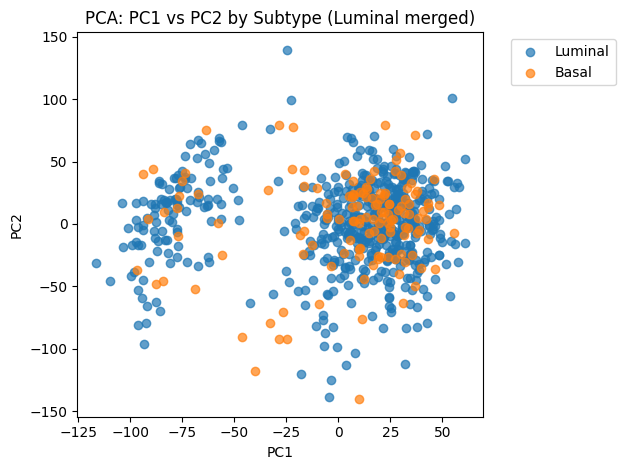

In [14]:
# After computing pcs and reloading clin_df…

pc_df = pd.DataFrame(
    pcs,
    index=clin_df['bcr_patient_barcode'].astype(str),
    columns=[f'PC{i+1}' for i in range(pcs.shape[1])]
)
pc_df = pc_df.join(clin_df.set_index('bcr_patient_barcode')['Subtype_merged'])

# Plot
plt.figure()
for group in pc_df['Subtype_merged'].unique():
    sel = pc_df['Subtype_merged'] == group
    plt.scatter(
        pc_df.loc[sel, 'PC1'],
        pc_df.loc[sel, 'PC2'],
        label=group,
        alpha=0.7
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 vs PC2 by Subtype (Luminal merged)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [16]:
# Assuming you’ve already loaded these:
# vst = pd.read_hdf('data/rna_seq_vst_filtered.h5', key='vst')
# clin = pd.read_hdf('data/clinical_matched_final.h5', key='clinical')

# 1) Build the merged subtype and keep-list again
clin['Subtype_merged'] = clin['Subtype'].replace({'LumA':'Luminal','LumB':'Luminal'})
keep_samples = clin.loc[
    clin['Subtype_merged'].isin(['Basal','Luminal']),
    'bcr_patient_barcode'
].astype(str).tolist()

# 2) Check overlaps
set_clin = set(keep_samples)
set_vst  = set(vst.columns)

print(f"Clinical Basal/Luminal IDs: {len(set_clin)}")
print(f"VST matrix columns:        {len(set_vst)}")
print(f"Intersection:              {len(set_clin & set_vst)}")
print("Example clin IDs not in VST:", list(set_clin - set_vst)[:5])
print("Example VST cols not in clin:", list(set_vst - set_clin)[:5])


Clinical Basal/Luminal IDs: 693
VST matrix columns:        693
Intersection:              0
Example clin IDs not in VST: ['TCGA-BH-A1FB', 'TCGA-E9-A5UO', 'TCGA-GM-A2DF', 'TCGA-OL-A5RX', 'TCGA-AN-A0XL']
Example VST cols not in clin: ['TCGA-LL-A5YM-01A-11R-A28M-07', 'TCGA-E9-A3Q9-01A-11R-A21T-07', 'TCGA-A2-A0EN-01A-13R-A084-07', 'TCGA-BH-A0AU-01A-11R-A12P-07', 'TCGA-OL-A5DA-01A-11R-A27Q-07']


In [17]:
# Truncate VST matrix columns from full sample IDs down to first 12 chars
vst.columns = [col[:12] for col in vst.columns]
print("Now VST columns look like:", vst.columns[:5])


Now VST columns look like: Index(['TCGA-GM-A2DL', 'TCGA-AC-A2QI', 'TCGA-AR-A24N', 'TCGA-D8-A1JU',
       'TCGA-A8-A0AD'],
      dtype='object')


In [18]:
# Build the list of Basal/Luminal patients
clin['Subtype_merged'] = clin['Subtype'].replace({'LumA':'Luminal','LumB':'Luminal'})
keep_samples = clin.loc[
    clin['Subtype_merged'].isin(['Basal','Luminal']),
    'bcr_patient_barcode'
].astype(str).tolist()

# Subset the truncated VST matrix
vst_sub = vst.loc[:, keep_samples]
print("Subset VST shape (genes × samples):", vst_sub.shape)


Subset VST shape (genes × samples): (17181, 693)


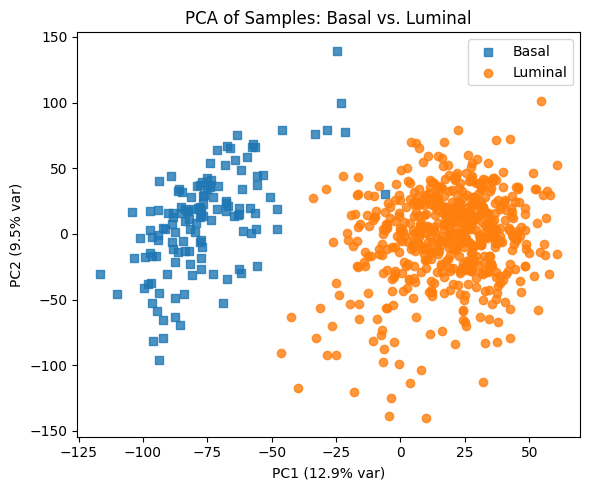

In [19]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Run PCA on your subsetted VST (genes × samples → samples × genes)
pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(vst_sub.T)   # shape = (n_samples, 2)

# 2) Build a DataFrame of PCs, keyed by patient barcode
pc_df = pd.DataFrame(
    pcs,
    index=vst_sub.columns,          # these are your 12-char barcodes
    columns=['PC1','PC2']
)

# 3) Attach the merged subtype label
#    (make sure `clin` has the 'Subtype_merged' column and 12-char 'bcr_patient_barcode')
pc_df = pc_df.join(
    clin.set_index('bcr_patient_barcode')['Subtype_merged'],
    how='left'
)

# 4) Plot PC1 vs PC2
plt.figure(figsize=(6,5))
for group, marker in [('Basal','s'), ('Luminal','o')]:
    sel = pc_df['Subtype_merged'] == group
    plt.scatter(
        pc_df.loc[sel,'PC1'],
        pc_df.loc[sel,'PC2'],
        label=group,
        marker=marker,
        alpha=0.8
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Samples: Basal vs. Luminal")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# Save your subsetted VST matrix (genes × samples) to HDF5
output_path = '../data/rna_seq_vst_basallum.h5'
vst_sub.to_hdf(output_path, key='vst_sub', mode='w')

print(f"Saved subsetted VST matrix to {output_path}")


Saved subsetted VST matrix to ../data/rna_seq_vst_basallum.h5
